# What a tree cannot see?
That is the hint Chris pointed out several times in his comments as the magic. We are exploring one aspect in this kernel. We first explore the idea on synthetic data, then apply it on the competition data. The improvement on synthetic data is drastic, but did not improve our LB. If your engineered features got you beyond 0.901 and this helps, leave a comment so we know it wasn't in vain. 


First, let's generate a dataset which consists of only two variables with close class distribution similar to the this competition.

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

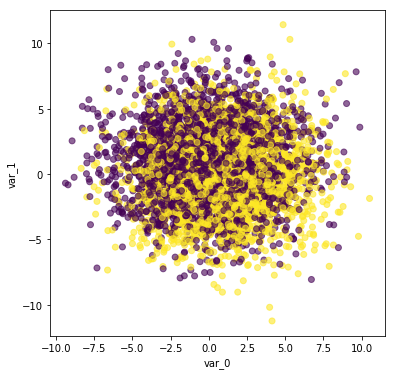

In [46]:
# lets generate a dataset
dataset=pd.DataFrame(np.zeros((5000,3)), columns=['var_0', 'var_1', 'target'])

dataset.loc[:2499, 'var_0'] = np.random.randn(2500) * 3 + 1
dataset.loc[:2499, 'var_1'] = np.random.randn(2500) * 3 + 0
dataset.loc[:2499, 'target'] = 1

dataset.loc[2500:, 'var_0'] = np.random.randn(2500) * 3 + 0
dataset.loc[2500:, 'var_1'] = np.random.randn(2500) * 3 + 1
dataset.loc[2500:, 'target'] = 0

dataset = dataset.sample(frac=1) # shuffle

plt.figure(figsize=(6, 6))
plt.scatter(dataset.var_0, dataset.var_1, c=dataset.target, alpha=0.6)
plt.xlabel('var_0')
plt.ylabel('var_1')
plt.show()

As known, decision trees like the data when the boundary is inline with axes which is not the case here. So naturally a tree based model (DecisionTreeRegressor) so the performance is expected to be poor (AUC of 0.6121). Here's the visualisation of the tree and histogram distributions in each axes.

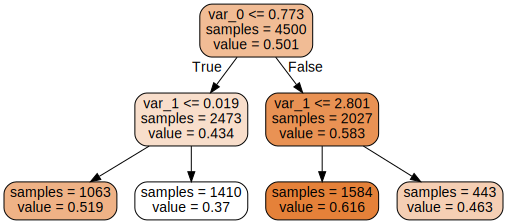

In [47]:
train, target = dataset.iloc[:, :2], dataset.target
cols = train.columns
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.1, random_state=2019)


#model = tree.DecisionTreeClassifier(max_leaf_nodes=8)
model = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(X_train, y_train)
#pred_val = model.predict_proba(valid[cols])[:,1]
pred_val = model.predict(X_valid)

# print('AUC = ',round( roc_auc_score(y_valid,pred_val),4 ) )


tree_graph = tree.export_graphviz(model, out_file=None, max_depth = 10,
    impurity = False, feature_names = cols, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

Now, let's take a look at variables distribution. They are quite similar to Santander's data, aren't they? 

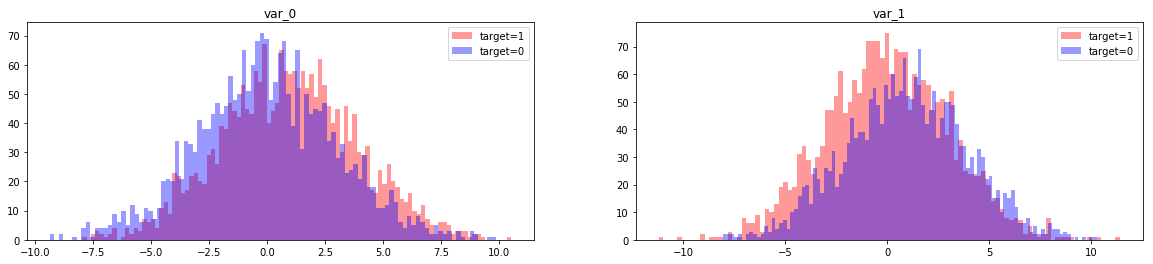

In [48]:
f,axs=plt.subplots(1,2,figsize=(20,4))
axs[0].hist(X_train.loc[target==1, 'var_0'], label='target=1', bins=100, color='red', alpha=0.4)
axs[0].hist(X_train.loc[target==0, 'var_0'], label='target=0',bins=100, color='blue' , alpha=0.4)
axs[0].set_title('var_0')
axs[0].legend()
axs[1].hist(X_train.loc[target==1, 'var_1'], label='target=1', bins=100, color='red', alpha=0.4)
axs[1].hist(X_train.loc[target==0, 'var_1'], label='target=0',bins=100, color='blue' , alpha=0.4)
axs[1].set_title('var_1')
axs[1].legend()
plt.show()

Ok, let's go back to the hint! what a decision tree **CANNOT** see? remember trees split using boundaries inline with axes. The workaround is to rotate the data. But we don't know much about the boundaries (the problem was solved if we knew), so instead we use the location of in-class means. Here, the data is rotated 45 degrees (using prior knowledge of how the data was generated! but the degree of rotation is not hard to find even without that knowledge).

In [49]:
dataset['var_0_plus_var_1'] = dataset['var_0'] + dataset['var_1']
dataset['var_0_minus_var_1'] = dataset['var_0'] - dataset['var_1']

Let's take another look at the scatter plot.

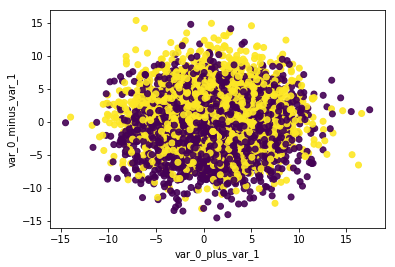

In [50]:
plt.scatter(dataset.var_0_plus_var_1, dataset.var_0_minus_var_1, c=dataset.target, alpha=0.9)
plt.xlabel('var_0_plus_var_1')
plt.ylabel('var_0_minus_var_1')
plt.show()

It seems quite similar to the original dataset. However, a decision tree should be able to split it using vertical and horizontal lines easier this time. Training the same model on the rotated data gets AUC of 0.6337! **0.0216** improvement from 0.6121.
Sounds familiar?

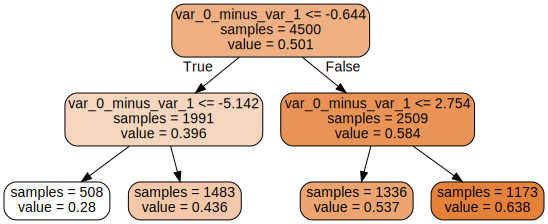

In [51]:
train, target = dataset.loc[:, ['var_0_minus_var_1', 'var_0_plus_var_1']], dataset.target
cols = train.columns
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.1, random_state=2019)


#model = tree.DecisionTreeClassifier(max_leaf_nodes=8)
model = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(X_train, y_train)
#pred_val = model.predict_proba(valid[cols])[:,1]
pred_val = model.predict(X_valid)

tree_graph = tree.export_graphviz(model, out_file=None, max_depth = 10,
    impurity = False, feature_names = cols, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

This rotation separates one of the histograms but collapse all the others:

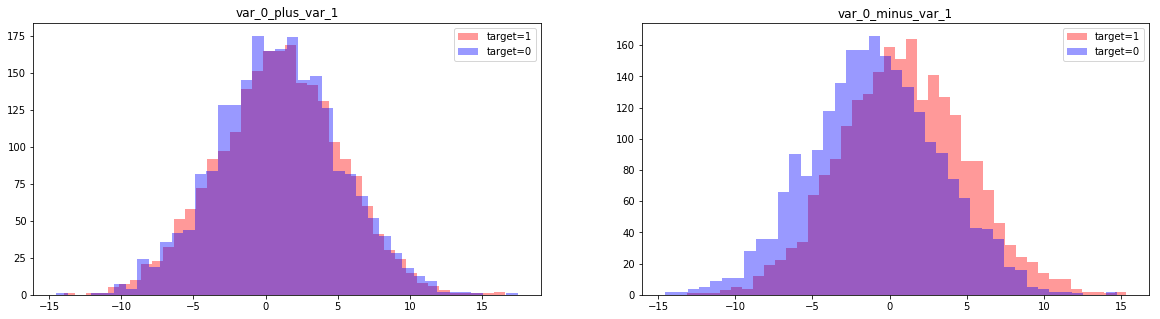

In [52]:
f,axs=plt.subplots(1,2,figsize=(20,5))
axs[0].hist(X_train.loc[target==1, 'var_0_plus_var_1'], label='target=1', bins=40, color='red', alpha=0.4)
axs[0].hist(X_train.loc[target==0, 'var_0_plus_var_1'], label='target=0',bins=40, color='blue' , alpha=0.4)
axs[0].set_title('var_0_plus_var_1')
axs[0].legend()
axs[1].hist(X_train.loc[target==1, 'var_0_minus_var_1'], label='target=1', bins=40, color='red', alpha=0.4)
axs[1].hist(X_train.loc[target==0, 'var_0_minus_var_1'], label='target=0',bins=40, color='blue' , alpha=0.4)
axs[1].set_title('var_0_minus_var_1')
axs[1].legend()
plt.show()

Now let's try to rotate the competition dataset systematically.

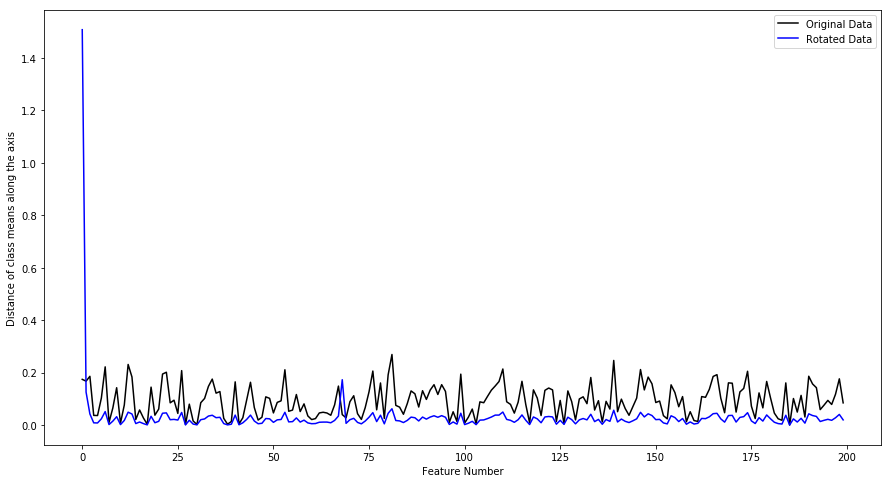

In [53]:
from sklearn.preprocessing import StandardScaler
reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
def plot_means(X_r,X_o):
    # Plotting min and max of each class
    d_mean_o=np.abs(X_o[ind0].mean(axis=0)-X_o[~ind0].mean(axis=0))
    d_mean_r=np.abs(X_r[ind0].mean(axis=0)-X_r[~ind0].mean(axis=0))
    plt.figure(figsize=(15,8))
    fn=np.arange(200)
    plt.plot(fn,d_mean_o,'k',label='Original Data')
    plt.plot(fn,d_mean_r,'b',label='Rotated Data')
    plt.xlabel('Feature Number');plt.ylabel('Distance of class means along the axis')
    plt.legend()

train = pd.read_csv('../input/train.csv')
train, target = train.iloc[:, 2:], train['target']

ss=StandardScaler()
ind0=target==0
train_scaled=ss.fit_transform(train)

x0m=train_scaled[ind0].mean(axis=0,keepdims=True)
x1m=train_scaled[~ind0].mean(axis=0,keepdims=True)
xm=np.r_[x0m,x1m]
L,s,R=np.linalg.svd(xm)
train_rotated=train_scaled @ R

plot_means(train_rotated,train_scaled)

You can see that all the distances has been accumulated in the first feature except for var_68. Now let's plot the histogram of the first feature and a random one.

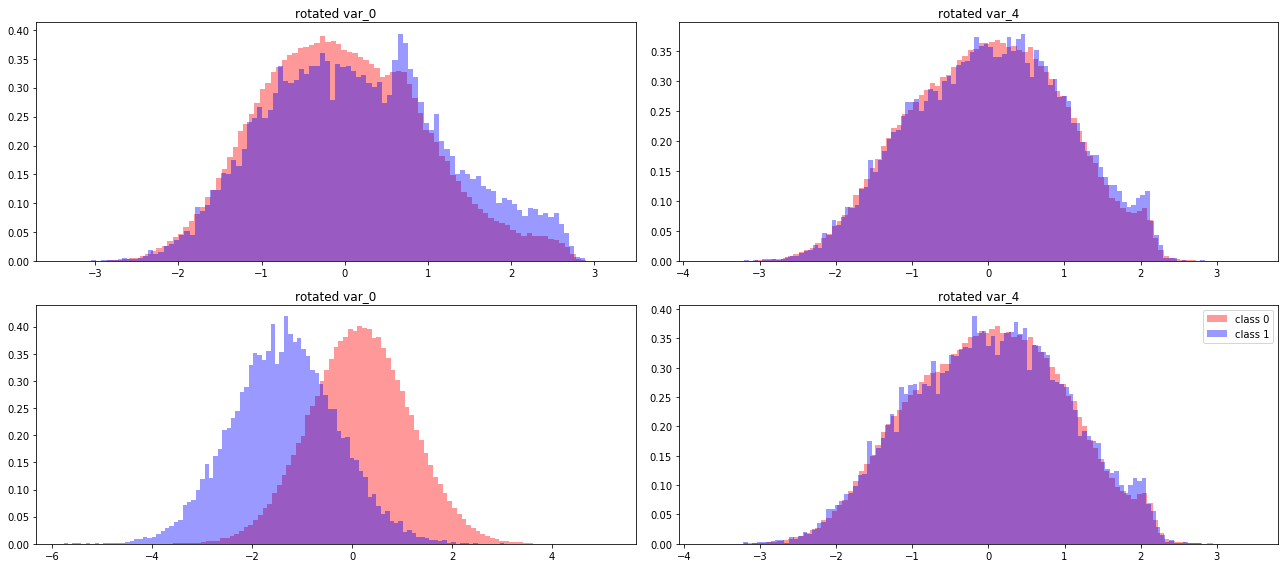

In [54]:
f,axs=plt.subplots(2,2,figsize=(18,8))
axs[0,0].hist(train_scaled[ind0,0], label='class 0', bins=100, color='r', alpha=0.4,density=True)
axs[0,0].hist(train_scaled[~ind0,0], label='class 1', bins=100, color='b', alpha=0.4,density=True)
axs[0,0].set_title('rotated var_0')
axs[0,1].hist(train_scaled[ind0,4], label='class 0', bins=100, color='r', alpha=0.4,density=True)
axs[0,1].hist(train_scaled[~ind0,4], label='class 1', bins=100, color='b', alpha=0.4,density=True)
axs[0,1].set_title('rotated var_4')
axs[1,0].hist(train_rotated[ind0,0], label='class 0', bins=100, color='r', alpha=0.4,density=True)
axs[1,0].hist(train_rotated[~ind0,0], label='class 1', bins=100, color='b', alpha=0.4,density=True)
axs[1,0].set_title('rotated var_0')
axs[1,1].hist(train_rotated[ind0,4], label='class 0', bins=100, color='r', alpha=0.4,density=True)
axs[1,1].hist(train_rotated[~ind0,4], label='class 1', bins=100, color='b', alpha=0.4,density=True)
axs[1,1].set_title('rotated var_4')
axs[1,1].legend()
plt.tight_layout()
plt.show()

But SVD does not mirror the axes. I remember somewhere in the discussions pointed that some features could be flipped (credit goes to the guy I don't remember). So let's try that and rotate again.

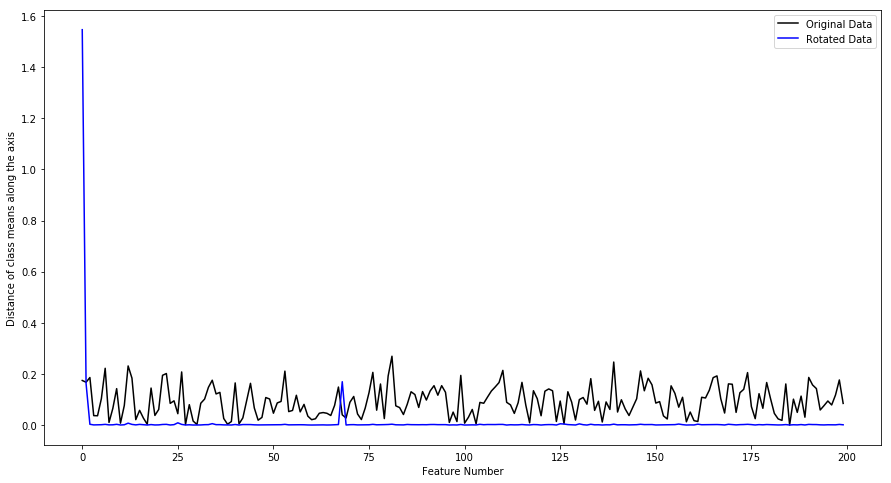

In [55]:
train.iloc[:,reverse_list]*=-1
train_scaled=ss.fit_transform(train)

x0m=train_scaled[ind0].mean(axis=0,keepdims=True)
x1m=train_scaled[~ind0].mean(axis=0,keepdims=True)
xm=np.r_[x0m,x1m]
L,s,R=np.linalg.svd(xm)
train_rotated=train_scaled @ R

plot_means(train_rotated,train_scaled)

This is interesting, now SVD can rotate the axes so all the features (except the infamous `var_68`) to be perfectly aligned with the axes. But it doesn't matter as we mentioned in another [kernel](https://www.kaggle.com/mhviraf/there-are-no-categorical-features), that variable is the residual of the PCA done on data in the processing. The distributions don't change much compared to the histograms above. Also the rotation matrix could be inspected to see the change of feature orders in the rotated data.

Although this rotation was not helpful here, we hope it'd be useful to someone later.